In [32]:
import gym
import tensorflow as tf
import numpy as np
import gym  #requires OpenAI gym installed
import matplotlib.pyplot as plt
import numpy as np
%timeit

In [33]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'bipedal-walker-harcore-v2': gym.make('BipedalWalkerHardcore-v2'),
    'bipedal-walker-v2': gym.make('BipedalWalker-v2')

}

In [34]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [35]:
env = envs["bipedal-walker-v2"]

tf.reset_default_graph()

input_dims = 24
state_placeholder = tf.placeholder(tf.float32, [None, input_dims]) 

def value_function(state):
    n_hidden = 256
    n_outputs = 1
    
    with tf.variable_scope("value_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden, tf.nn.elu, init_xavier)
        hidden3 = tf.layers.dense(hidden2, n_hidden, tf.nn.elu, init_xavier) 

        V = tf.layers.dense(hidden3, n_outputs, None, init_xavier)
    return V


def policy_network(state, n_outputs = 4):
    n_hidden = 64
    
    with tf.variable_scope("policy_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden, tf.nn.elu, init_xavier)
        mu = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        sigma = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        sigma = tf.nn.softplus(sigma) + 1e-5
        norm_dist = tf.contrib.distributions.Normal(mu, sigma)
        action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
        action_tf_var = tf.clip_by_value(
            action_tf_var, env.action_space.low[0], 
            env.action_space.high[0])
    return action_tf_var, norm_dist

lr_actor = 0.0002  #set learning rates
lr_critic = 0.001

# define required placeholders
action_placeholder = tf.placeholder(tf.float32)
delta_placeholder = tf.placeholder(tf.float32)
target_placeholder = tf.placeholder(tf.float32)

action_tf_var, norm_dist = policy_network(state_placeholder)
V = value_function(state_placeholder)

# define actor (policy) loss function
loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder
training_op_actor = tf.train.AdamOptimizer(
    lr_actor, name='actor_optimizer').minimize(loss_actor)

# define critic (state-value) loss function
loss_critic = tf.reduce_mean(tf.squared_difference(
                             tf.squeeze(V), target_placeholder))
training_op_critic = tf.train.AdamOptimizer(
        lr_critic, name='critic_optimizer').minimize(loss_critic)
################################################################
#Training loop
gamma = 0.99        #discount factor
num_episodes = 10
checkpoint_interval = 1
num_steps = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    episode_history = []
    steps_history = []
    for episode in range(num_episodes):
        #receive initial state from E
        state = env.reset()   # state.shape -> (2,)
        reward_total = 0 
        steps = 0
        done = False
        while (not done):
                
            #Sample action according to current policy
            #action.shape = (1,4)
            action  = sess.run(action_tf_var, feed_dict={
                          state_placeholder: state.reshape(1, -1)})
            #Execute action and observe reward & next state from E
            # next_state shape=(2,)    
            #env.step() requires input shape = (1,)
            next_state, reward, done, _ = env.step(
                                    np.squeeze(action, axis=0)) 
            steps +=1
            reward_total += reward
            #V_of_next_state.shape=(1,1)
            V_of_next_state = sess.run(V, feed_dict = 
                    {state_placeholder: next_state.reshape(1, -1)})  
            #Set TD Target
            #target = r + gamma * V(next_state)     
            target = reward + gamma * np.squeeze(V_of_next_state) 
            
            # td_error = target - V(s)
            #needed to feed delta_placeholder in actor training
            td_error = target - np.squeeze(sess.run(V, feed_dict = 
                        {state_placeholder: state.reshape(1, -1)})) 
            
            #Update actor by minimizing loss (Actor training)
            _, loss_actor_val  = sess.run(
                [training_op_actor, loss_actor], 
                feed_dict={action_placeholder: np.squeeze(action), 
                state_placeholder: state.reshape(1, -1), 
                delta_placeholder: td_error})
            #Update critic by minimizinf loss  (Critic training)
            _, loss_critic_val  = sess.run(
                [training_op_critic, loss_critic], 
                feed_dict={state_placeholder: state.reshape(1, -1), 
                target_placeholder: target})
            loss_critic_vals.append(loss_critic_val)
            loss_actor_vals.append(loss_actor_val)

            
            state = next_state
            #end while
        episode_history.append(reward_total)
        steps_history.append(steps)
        print("Episode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(
            episode, steps, reward_total))
        if (episode + 1) % checkpoint_interval == 0:
            save_path = saver.save(sess, "./tmp/pre_trained_step_%d.ckpt" % episode)
    np.save("summary.npy", {'episode_history': episode_history, 'steps_history': steps_history})

NameError: name 'loss_critic_vals' is not defined

In [37]:
sup = np.load("./tmp/pre_trained_0.000020_0.000100/summary_4999_0.000020_0.000100.npy", allow_pickle=True)
sup.shape = [1]
sup = sup[0]


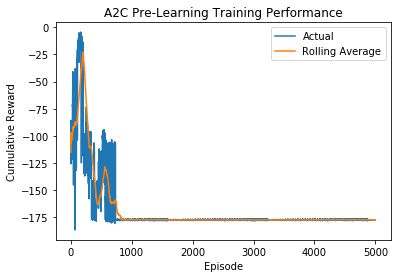

In [40]:
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("A2C Pre-Learning Training Performance")
plt.plot(np.array(sup['episode_history']))
plt.plot(rolling_average(np.array(sup['episode_history']), window_size=100))
plt.legend(["Actual", "Rolling Average"])
plt.savefig("a2c_pretrained_performance")